In [1]:
import pandas as pd

# Load the TSV files and specify column names
train_df = pd.read_csv('train.tsv', sep='\t', header=None, names=['Comment', 'Emotion', 'Comment ID'])
dev_df = pd.read_csv('dev.tsv', sep='\t', header=None, names=['Comment', 'Emotion', 'Comment ID'])
test_df = pd.read_csv('test.tsv', sep='\t', header=None, names=['Comment', 'Emotion', 'Comment ID'])

## Selecting 1 emotion label for rows having multiple

In [2]:
def split_and_duplicate_rows(df):
    df['Emotion'] = df['Emotion'].astype(str).apply(lambda x: x.split(',')[0])

    # Convert 'Emotion' column to integer
    df['Emotion'] = df['Emotion'].astype(int)

    return df

# Apply the function to each DataFrame
train_df = split_and_duplicate_rows(train_df)
dev_df = split_and_duplicate_rows(dev_df)
test_df = split_and_duplicate_rows(test_df)

# Convert the labels to integers and ensure they are of dtype long
train_df['Emotion'] = train_df['Emotion'].astype(int)
dev_df['Emotion'] = dev_df['Emotion'].astype(int)
test_df['Emotion'] = test_df['Emotion'].astype(int)

# Verify the result
print(dev_df.head())

                                             Comment  Emotion Comment ID
0  Is this in New Orleans?? I really feel like th...       27    edgurhb
1  You know the answer man, you are programmed to...        4    ee84bjg
2               I've never been this sad in my life!       25    edcu99z
3  The economy is heavily controlled and subsidiz...        4    edc32e2
4  He could have easily taken a real camera from ...       20    eepig6r


## Reducing number of emotion labels to 6 from 28

In [3]:
# Define a mapping to reduce numeric emotions from 28 to 7 categories (including neutral)
emotion_reduction_mapping = {
    # Happiness
    0: 0,  # admiration -> happiness
    1: 0,  # amusement -> happiness
    13: 0, # excitement -> happiness
    15: 0, # gratitude -> happiness
    21: 0, # pride -> happiness
    17: 0, # joy -> happiness
    18: 0, # love -> happiness
    20: 0, # optimism -> happiness
    23: 0, # relief -> happiness

    # Surprise
    22: 1, # realization -> surprise
    26: 1, # surprise -> surprise

    # Sadness
    16: 2, # grief -> sadness
    25: 2, # sadness -> sadness
    9: 2,  # disappointment -> sadness
    12: 2, # embarrassment -> sadness

    # Anger
    2: 3,  # anger -> anger
    3: 3,  # annoyance -> anger

    # Disgust
    11: 4, # disgust -> disgust
    10: 4, # disapproval -> disgust

    # Fear
    14: 5, # fear -> fear
    19: 5, # nervousness -> fear

    # Neutral
    27: 6  # neutral -> neutral
}

def reduce_emotions_numeric(df):
    # Map the emotions to the reduced categories
    df['Emotion'] = df['Emotion'].apply(lambda x: emotion_reduction_mapping.get(x, None))

    # Drop rows with unmapped or invalid emotions
    df.dropna(subset=['Emotion'], inplace=True)

    # Ensure Emotion column is of integer type
    df['Emotion'] = df['Emotion'].astype(int)

    return df

# Apply the mapping to all datasets
train_df = reduce_emotions_numeric(train_df)
dev_df = reduce_emotions_numeric(dev_df)
test_df = reduce_emotions_numeric(test_df)

# Check the results
print(train_df.head())


                                             Comment  Emotion Comment ID
0  My favourite food is anything I didn't have to...        6    eebbqej
1  Now if he does off himself, everyone will thin...        6    ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING        3    eezlygj
3                        To make her feel threatened        5    ed7ypvh
4                             Dirty Southern Wankers        3    ed0bdzj


In [4]:
# Inspect the unique values in the Emotion column
print("Train Emotion Types and Values:", train_df['Emotion'].apply(type).unique(), train_df['Emotion'].unique())
print("Dev Emotion Types and Values:", dev_df['Emotion'].apply(type).unique(), dev_df['Emotion'].unique())
print("Test Emotion Types and Values:", test_df['Emotion'].apply(type).unique(), test_df['Emotion'].unique())


Train Emotion Types and Values: [<class 'int'>] [6 3 5 1 0 2 4]
Dev Emotion Types and Values: [<class 'int'>] [6 2 0 3 4 5 1]
Test Emotion Types and Values: [<class 'int'>] [2 0 6 3 5 4 1]


In [5]:
dev_df.head()

,Comment,Emotion,Comment ID
0,Is this in New Orleans?? I really feel like th...,6,edgurhb
2,I've never been this sad in my life!,2,edcu99z
4,He could have easily taken a real camera from ...,0,eepig6r
5,"Thank you for your vote of confidence, but we ...",0,eczm50f
6,Wah Mum other people call me on my bullshit an...,3,ed4yr9r


## Data Augmentation

In [6]:
import nlpaug.augmenter.word as naw

# Define the synonym augmenter
synonym_aug = naw.SynonymAug(aug_src='wordnet')

# Function to augment data for a specific emotion
def augment_emotion_rows(df, emotion, augmenter, num_augments=2):
    # Filter rows for the specified emotion
    emotion_rows = df[df['Emotion'] == emotion].copy()
    augmented_texts = []

    # Augment each comment
    for text in emotion_rows['Comment']:
        for _ in range(num_augments):
            augmented_texts.append(augmenter.augment(text))

    # Create a new DataFrame with augmented data
    augmented_df = pd.DataFrame({
        'Comment': augmented_texts,
        'Emotion': [emotion] * len(augmented_texts)
    })

    return augmented_df

# Augment emotions 1 to 5
augmented_dfs = []
for emotion in range(1, 6):
    augmented_dfs.append(augment_emotion_rows(train_df, emotion, synonym_aug, num_augments=3))

# Combine all augmented data
augmented_data = pd.concat(augmented_dfs)

# Add augmented data to the original training dataset
train_df = pd.concat([train_df, augmented_data]).reset_index(drop=True)

# Verify the class distribution
print(train_df['Emotion'].value_counts())


Emotion
3    14740
0    12843
6    12823
4     8924
2     8860
1     5796
5     2460
Name: count, dtype: int64


## Preprocessing

In [7]:
# Updated preprocess function
import re

def preprocess(text):
    if isinstance(text, list):  # If the entry is a list, join it into a string
        text = ' '.join(text)
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to each DataFrame
train_df['Comment'] = train_df['Comment'].apply(preprocess)
dev_df['Comment'] = dev_df['Comment'].apply(preprocess)
test_df['Comment'] = test_df['Comment'].apply(preprocess)

# Drop any rows with NaN values in the Comment column
train_df.dropna()
dev_df.dropna()
test_df.dropna()


,Comment,Emotion,Comment ID
0,im really sorry about your situation although ...,2,eecwqtt
1,its wonderful because its awful at not with,0,ed5f85d
2,kings fan here good luck to you guys will be a...,0,een27c3
3,i didnt know that thank you for teaching me so...,0,eelgwd1
4,they got bored from haunting earth for thousan...,6,eem5uti
...,...,...,...
5421,easy just include name to continue to torment ...,6,edy4kl7
5422,thanks i was diagnosed with bp 1 after the hos...,0,efeeasc
5424,daddy issues name,6,efbiugo
5425,so glad i discovered that subreddit a couple m...,0,efbvgp9


In [8]:
print(train_df.head())
print(dev_df.head())
print(test_df.head())

                                             Comment  Emotion Comment ID
0  my favourite food is anything i didnt have to ...        6    eebbqej
1  now if he does off himself everyone will think...        6    ed00q6i
2                     why the fuck is bayless isoing        3    eezlygj
3                        to make her feel threatened        5    ed7ypvh
4                             dirty southern wankers        3    ed0bdzj
                                             Comment  Emotion Comment ID
0  is this in new orleans i really feel like this...        6    edgurhb
2                 ive never been this sad in my life        2    edcu99z
4  he could have easily taken a real camera from ...        0    eepig6r
5  thank you for your vote of confidence but we s...        0    eczm50f
6  wah mum other people call me on my bullshit an...        3    ed4yr9r
                                             Comment  Emotion Comment ID
0  im really sorry about your situation although ..

## Plotting a graph to see value distribution in the dataset

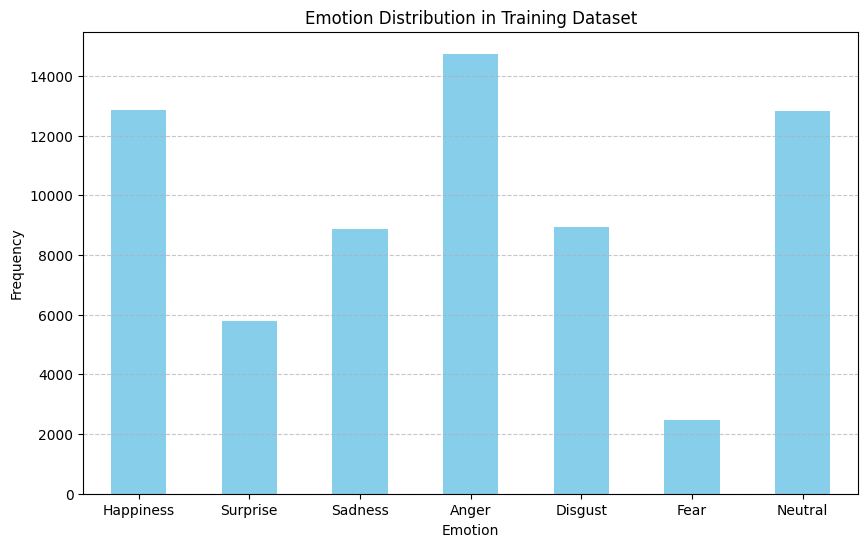

In [10]:
import matplotlib.pyplot as plt

emotion_labels = [
    "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Neutral"
]
# Ensure the Emotion column values are properly mapped to labels
train_df['Emotion_Label'] = train_df['Emotion'].map({i: label for i, label in enumerate(emotion_labels)})

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
train_df['Emotion_Label'].value_counts().reindex(emotion_labels).plot(kind='bar', color='skyblue')  # Sort by defined order
plt.title('Emotion Distribution in Training Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Pip installing packages

In [ ]:
!pip install transformers torch

In [ ]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.5 MB/s eta 0:00:00


## Model Tokenizing and Training

In [11]:
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_df['Comment'].tolist(), truncation=True, padding=True)
dev_encodings = tokenizer(dev_df['Comment'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['Comment'].tolist(), truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are torch.long
        return item

    def __len__(self):
        return len(self.labels)

# Convert the labels to a list or a NumPy array before creating the datasets
train_labels = train_df['Emotion'].tolist()  # or train_df['Emotion'].values for NumPy array
dev_labels = dev_df['Emotion'].tolist()
test_labels = test_df['Emotion'].tolist()

# Create datasets
train_dataset = EmotionDataset(train_encodings, train_labels)
dev_dataset = EmotionDataset(dev_encodings, dev_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)


In [15]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import pickle
from transformers import TrainerCallback

# Load BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=28)

# Custom Callback to save model after each epoch
class SaveModelCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        epoch = int(state.epoch)
        model_path = f'/content/model2_epoch_{epoch}.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved at {model_path}")

# Updated training arguments
training_args = TrainingArguments(
    output_dir='./results',             # Directory for model checkpoints
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    learning_rate=1e-5,                # Slightly increased learning rate for faster convergence
    per_device_train_batch_size=16,    # Reduced batch size if memory constraints arise
    per_device_eval_batch_size=16,     # Matching eval batch size to train batch size
    num_train_epochs=5,               # Adjusted to prevent overfitting; consider early stopping
    weight_decay=0.01,                 # Standard weight decay for regularization
    save_strategy="epoch",             # Save checkpoints after each epoch
    save_total_limit=3,                # Keep only the last 3 checkpoints
    logging_dir='./logs',              # Directory for logs
    logging_steps=50,                  # Log more frequently for closer monitoring
    warmup_steps=300,                  # Reduce warmup steps for smoother learning rate ramp
    lr_scheduler_type="cosine",        # Use a cosine schedule for learning rate decay
    load_best_model_at_end=True,       # Automatically load the best model after training
    metric_for_best_model="eval_loss", # Use evaluation loss to determine the best model
    gradient_accumulation_steps=2,     # Accumulate gradients for larger effective batch size                       # Use mixed precision training for faster computation
    seed=42                            # Seed for reproducibility
)

trainer = Trainer(
    model=model,                          # Your model instance
    args=training_args,                   # Training arguments
    train_dataset=train_dataset,          # Training dataset
    eval_dataset=dev_dataset,            # Evaluation dataset
    tokenizer=tokenizer,                  # Tokenizer for preprocessing
    callbacks=[SaveModelCallback()],      # Add the custom callback to save models
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,0.923000,0.828950
2,0.570400,0.910917
4,0.404500,0.964686


Model saved at /content/model2_epoch_0.pkl
Model saved at /content/model2_epoch_2.pkl
Model saved at /content/model2_epoch_2.pkl
Model saved at /content/model2_epoch_4.pkl
Model saved at /content/model2_epoch_4.pkl


TrainOutput(global_step=10380, training_loss=0.7031589083588882, metrics={'train_runtime': 3155.4669, 'train_samples_per_second': 105.287, 'train_steps_per_second': 3.29, 'total_flos': 2.031675484811347e+16, 'train_loss': 0.7031589083588882, 'epoch': 4.998796051047435})

In [17]:
from torch.utils.data import DataLoader

model.eval()

train_loader = DataLoader(train_dataset, batch_size = 16)

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in train_loader:
        # Move input data to the appropriate device
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['labels'].to('cuda' if torch.cuda.is_available() else 'cpu')

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to predicted labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        # Store true and predicted labels
        true_labels.extend(true)
        predicted_labels.extend(preds)



## Precision Metrics

In [18]:
from sklearn.metrics import classification_report

# Generate a classification report (precision, recall, f1-score, support)
report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(7)])  # Adjust if needed
print(report)

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     12843
           1       0.65      0.68      0.66      5796
           2       0.75      0.64      0.69      8860
           3       0.75      0.68      0.72     14740
           4       0.59      0.65      0.62      8924
           5       0.71      0.72      0.71      2460
           6       0.71      0.78      0.75     12823

    accuracy                           0.73     66446
   macro avg       0.72      0.72      0.72     66446
weighted avg       0.74      0.73      0.73     66446



Classification Report:

              precision    recall  f1-score   support

   Happiness       0.88      0.89      0.88     12843
    Surprise       0.65      0.68      0.66      5796
     Sadness       0.75      0.64      0.69      8860
       Anger       0.75      0.68      0.72     14740
     Disgust       0.59      0.65      0.62      8924
        Fear       0.71      0.72      0.71      2460
     Neutral       0.71      0.78      0.75     12823

    accuracy                           0.73     66446
   macro avg       0.72      0.72      0.72     66446
weighted avg       0.74      0.73      0.73     66446



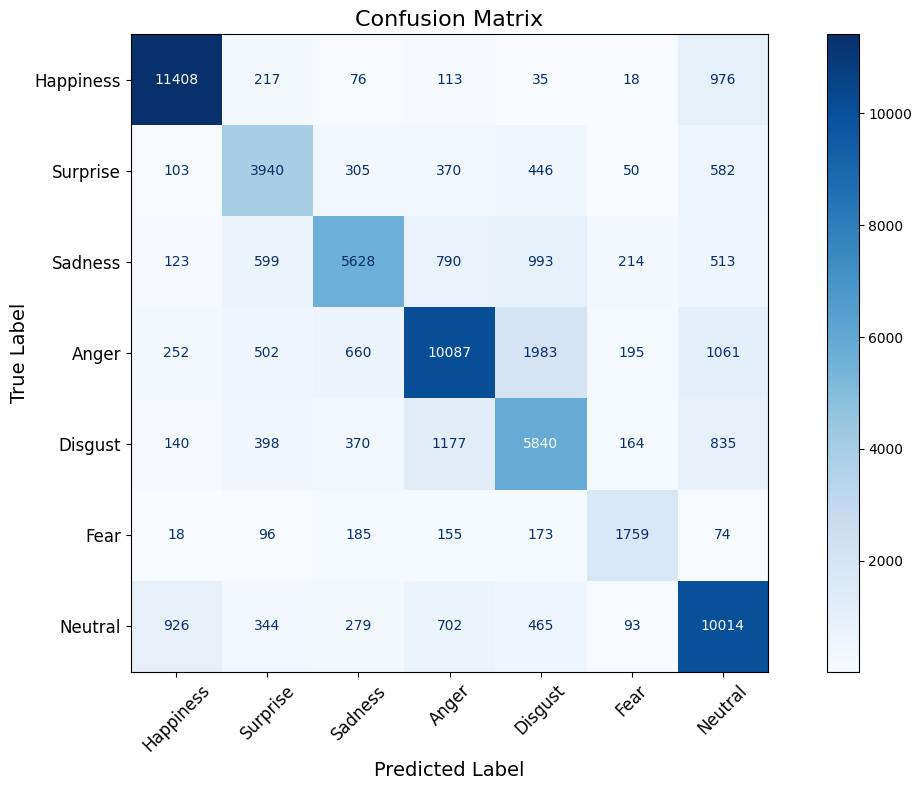

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=[
    "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Neutral"
])
print("Classification Report:\n")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix with better formatting
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Neutral"
])
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Customize the appearance
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=12)               # Adjust y-axis label size
plt.tight_layout()                    # Ensure everything fits without overlap
plt.show()



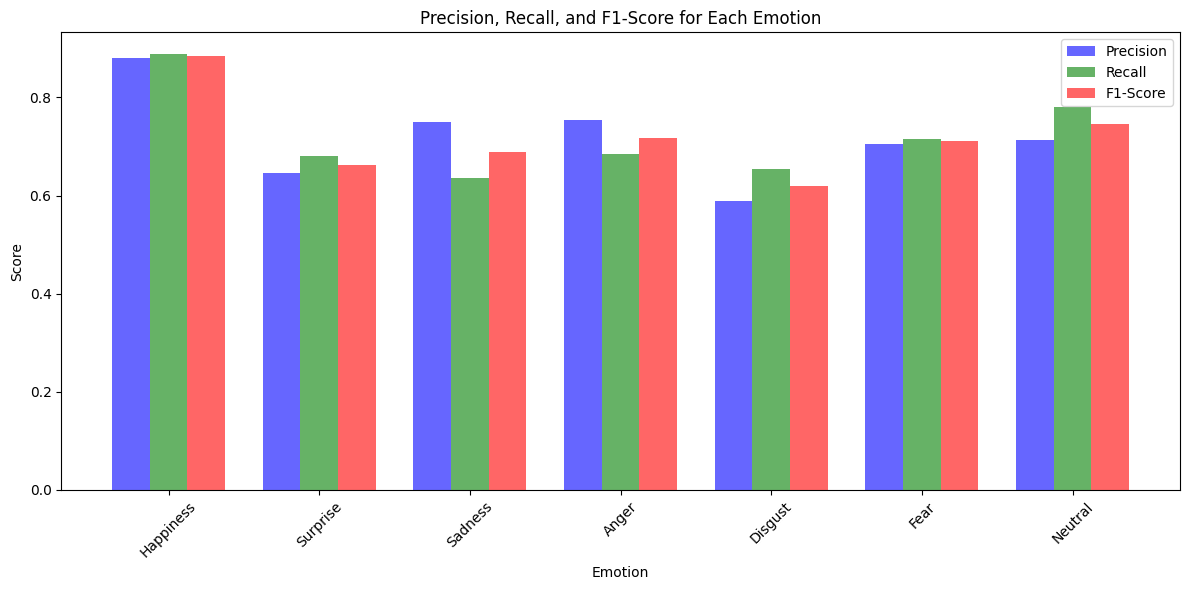

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

emotion_labels = [
    "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Neutral"
]
# Calculate precision, recall, and f1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=range(len(emotion_labels)))

# Create a bar plot
x = range(len(precision))  # Number of classes

plt.figure(figsize=(12, 6))
bar_width = 0.25  # Adjust for spacing between bars
plt.bar([i - bar_width for i in x], precision, width=bar_width, alpha=0.6, label='Precision', color='b')
plt.bar(x, recall, width=bar_width, alpha=0.6, label='Recall', color='g')
plt.bar([i + bar_width for i in x], f1, width=bar_width, alpha=0.6, label='F1-Score', color='r')
plt.xlabel('Emotion')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Emotion')
plt.xticks(x, emotion_labels, rotation=45)  # Use emotion labels instead of numeric labels
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


## Saving the Model as a pickle file

In [ ]:
import torch
import pickle
from transformers import BertForSequenceClassification

# Example: Assume `model` is your fine-tuned BERT model
model_path = '/content/final_emotion_model.pkl'

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_path}")


Model saved to /content/final_emotion_model.pkl


In [ ]:
import pickle

# Specify the path to your .pkl file
file_path = "/content/final_emotion_model.pkl"

# Open and load the .pkl file
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Display the loaded data (optional)
print(data)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
import pickle
from transformers import BertTokenizer

# Specify the path to the saved model
model_path = './final_emotion_model.pkl'


# Load the model
with open(model_path, 'rb') as f:
    model = pickle.load(f)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print("Model loaded successfully.")

Model loaded successfully.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rishabhkausish/reddit-depression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rishabhkausish/reddit-depression-dataset/versions/1


In [24]:
import os

path = "/root/.cache/kagglehub/datasets/rishabhkausish/reddit-depression-dataset/versions/1"
files = os.listdir(path)
print(files)

['reddit_depression_dataset.csv']


In [25]:
import pandas as pd

file_path = os.path.join(path, "reddit_depression_dataset.csv")
data = pd.read_csv(file_path)
data

<ipython-input-25-3b1000ad603b>:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,NaN,0.0
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0
2,47957,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0
3,47959,DeepThoughts,"""I want to be like water. I want to slip throu...",NaN,25.0,1.416512e+09,2.0,0.0
4,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0
...,...,...,...,...,...,...,...,...
2470773,10742224,depression,Alone as usual,I just argued with my mom an hour ago; she alw...,9.0,1.672529e+09,6.0,1.0
2470774,10742230,depression,Help needed urgently!,OK basically non of my friend's or family invi...,5.0,1.672530e+09,7.0,1.0
2470775,10742232,depression,I know what your thinking,Don't do It. Not today. Its gonna be ok if you...,10.0,1.672530e+09,8.0,1.0
2470776,10742243,depression,how do I stop having such a cynical view on ma...,"So I don't know, I've recently realized that t...",8.0,1.672531e+09,9.0,1.0


In [26]:
# Updated preprocess function
import re

def preprocess(text):
    if isinstance(text, list):  # If the entry is a list, join it into a string
        text = ' '.join(text)
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [27]:
# Fill NaN and Apply preprocessing to each DataFrame
data['body'] = data['body'].fillna('')  # Replace NaN with an empty string
data['body'] = data['body'].apply(preprocess)

# Drop rows where the 'body' column is NaN
data = data[data['body'].str.strip() != '']
data

,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
0,47951,DeepThoughts,Deep thoughts underdog,only when we start considering ourselves the 9...,4.0,1.405309e+09,NaN,0.0
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",anyway human morality is a joke so long as the...,4.0,1.410568e+09,1.0,0.0
2,47957,DeepThoughts,Rebirth!,hello i am the new guy in charge here besides ...,6.0,1.416458e+09,1.0,0.0
4,47960,DeepThoughts,Who am I?,you could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0
5,47969,DeepThoughts,What is the limit of the knowledge and power a...,personally i think its infinite we will always...,8.0,1.416684e+09,23.0,0.0
...,...,...,...,...,...,...,...,...
2470773,10742224,depression,Alone as usual,i just argued with my mom an hour ago she alwa...,9.0,1.672529e+09,6.0,1.0
2470774,10742230,depression,Help needed urgently!,ok basically non of my friends or family invit...,5.0,1.672530e+09,7.0,1.0
2470775,10742232,depression,I know what your thinking,dont do it not today its gonna be ok if you pu...,10.0,1.672530e+09,8.0,1.0
2470776,10742243,depression,how do I stop having such a cynical view on ma...,so i dont know ive recently realized that the ...,8.0,1.672531e+09,9.0,1.0


In [28]:
# Function to preprocess a single text entry
def preprocess_text(text, tokenizer, max_length=128):
    return tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")

In [29]:
import torch
model = model.to(torch.device('cuda'))

def predict_label(text):
    # Preprocess the text
    inputs = preprocess_text(text, tokenizer, max_length=128)

    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform inference without gradient calculation
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    return predicted_label

In [30]:
import pandas as pd

# Randomly select 50,000 rows with label = 1
label_1_sample = data[data['label'] == 1].sample(n=50000, random_state=42)

# Randomly select 50,000 rows with label = 0
label_0_sample = data[data['label'] == 0].sample(n=50000, random_state=42)

# Combine the two subsets
test_df = pd.concat([label_1_sample, label_0_sample]).reset_index(drop=True)

# Apply the predict_emotion function to the test subset
test_df['emotion'] = test_df['body'].apply(predict_label)

# Display the result
print(test_df)


      Unnamed: 0     subreddit  \
0       10554694    depression   
1        9438678    depression   
2       10215817    depression   
3        9033471  SuicideWatch   
4        8530484  SuicideWatch   
...          ...           ...   
99995    1930308     teenagers   
99996    2353851     teenagers   
99997    3325868     teenagers   
99998    5653935     teenagers   
99999    3647848     teenagers   

                                                   title  \
0                                 Nothing feels worth it   
1      While volunteering with a children's charity, ...   
2      I'm so depressed, and my "supports" aren't hel...   
3                            I am a terrible person&lt;3   
4      I can't do this anymore and I don't know if ca...   
...                                                  ...   
99995                                                 Hi   
99996  The girl who was reading a suicide note on You...   
99997                        Aight bois i need your

In [31]:
# Check the number of rows for each condition
condition_1 = len(test_df[(test_df['emotion'].isin([2, 3, 4, 5])) & (test_df['label'] == 1)])
condition_2 = len(test_df[(test_df['emotion'].isin([0, 1, 6])) & (test_df['label'] == 0)])
condition_3 = len(test_df[(test_df['emotion'].isin([2, 3, 4, 5])) & (test_df['label'] == 0)])
condition_4 = len(test_df[(test_df['emotion'].isin([0, 1, 6])) & (test_df['label'] == 1)])

# Print the results
print(f"Number of rows where emotion is in [2, 3, 4, 5] and label = 1: {condition_1}")
print(f"Number of rows where emotion is in [0, 1, 6] and label = 0: {condition_2}")
print(f"Number of rows where emotion is in [2, 3, 4, 5] and label = 0: {condition_3}")
print(f"Number of rows where emotion is in [0, 1, 6] and label = 1: {condition_4}")


Number of rows where emotion is in [2, 3, 4, 5] and label = 1: 28058
Number of rows where emotion is in [0, 1, 6] and label = 0: 37439
Number of rows where emotion is in [2, 3, 4, 5] and label = 0: 12561
Number of rows where emotion is in [0, 1, 6] and label = 1: 21942


Accuracy: 0.41
Precision: 0.43
Recall: 0.56
F1 Score: 0.49


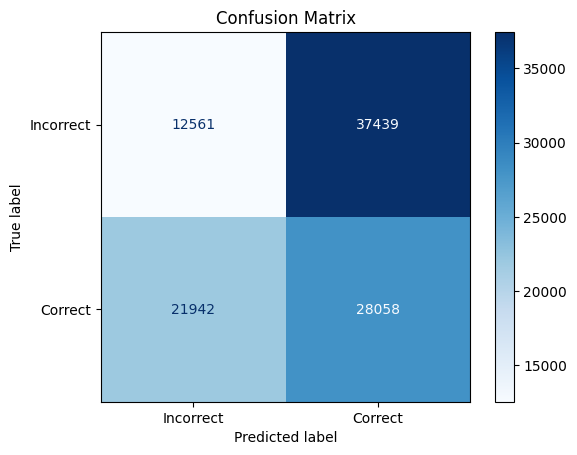

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the logic for predictions being correct or incorrect
def is_correct_prediction(row):
    if (row['emotion'] in [2, 3, 4, 5] and row['label'] == 1) or (row['emotion'] in [0, 1, 6] and row['label'] == 0):
        return 1  # Correct
    elif (row['emotion'] in [2, 3, 4, 5] and row['label'] == 0) or (row['emotion'] in [0, 1, 6] and row['label'] == 1):
        return 0  # Incorrect
    else:
        return 0  # Default to incorrect if no conditions match

# Apply the logic to the DataFrame
test_df['predicted_correct'] = test_df.apply(is_correct_prediction, axis=1)

# Actual labels and predictions for evaluation
y_true = test_df['label']
y_pred = test_df['predicted_correct']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect', 'Correct'])
disp.plot(cmap='Blues', values_format='d')

# Add title and labels
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.66
Precision: 0.69
Recall: 0.56
F1 Score: 0.62


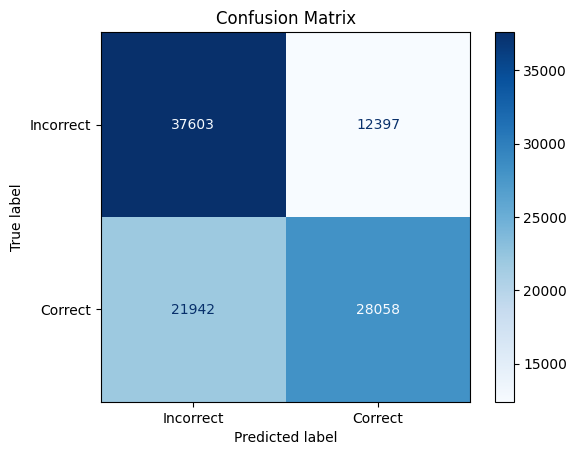

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the logic for predictions being correct or incorrect
def is_correct_prediction(row):
    if (row['emotion'] in [2, 3, 4, 5] and row['label'] == 1) or (row['emotion'] in [0, 1] and row['label'] == 0):
        return 1  # Correct
    elif (row['emotion'] in [2, 3, 4, 5] and row['label'] == 0) or (row['emotion'] in [0, 1] and row['label'] == 1):
        return 0  # Incorrect
    else:
        return 0  # Default to incorrect if no conditions match

# Apply the logic to the DataFrame
test_df['predicted_correct'] = test_df.apply(is_correct_prediction, axis=1)

# Actual labels and predictions for evaluation
y_true = test_df['label']
y_pred = test_df['predicted_correct']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect', 'Correct'])
disp.plot(cmap='Blues', values_format='d')

# Add title and labels
plt.title('Confusion Matrix')
plt.show()




Accuracy: 0.67
Precision: 0.72
Recall: 0.58
F1 Score: 0.64


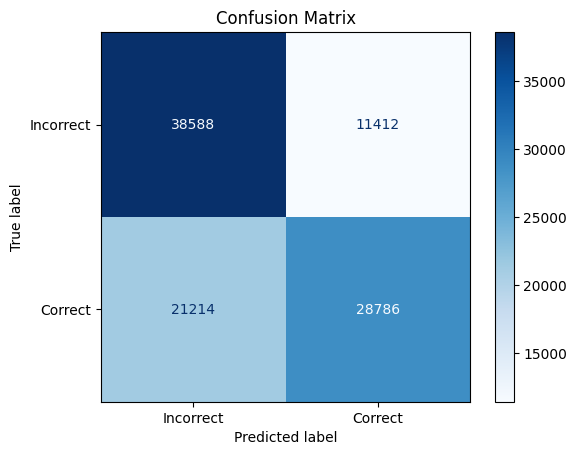

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the logic for predictions being correct or incorrect
def is_correct_prediction(row):
    if (row['emotion'] in [1,2, 3, 4, 5] and row['label'] == 1) or (row['emotion'] in [0] and row['label'] == 0):
        return 1  # Correct
    elif (row['emotion'] in [1, 2, 3, 4, 5] and row['label'] == 0) or (row['emotion'] in [0] and row['label'] == 1):
        return 0  # Incorrect
    else:
        return 0  # Default to incorrect if no conditions match

# Apply the logic to the DataFrame
test_df['predicted_correct'] = test_df.apply(is_correct_prediction, axis=1)

# Actual labels and predictions for evaluation
y_true = test_df['label']
y_pred = test_df['predicted_correct']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect', 'Correct'])
disp.plot(cmap='Blues', values_format='d')

# Add title and labels
plt.title('Confusion Matrix')
plt.show()




Accuracy: 0.80
Precision: 0.78
Recall: 0.83
F1 Score: 0.81


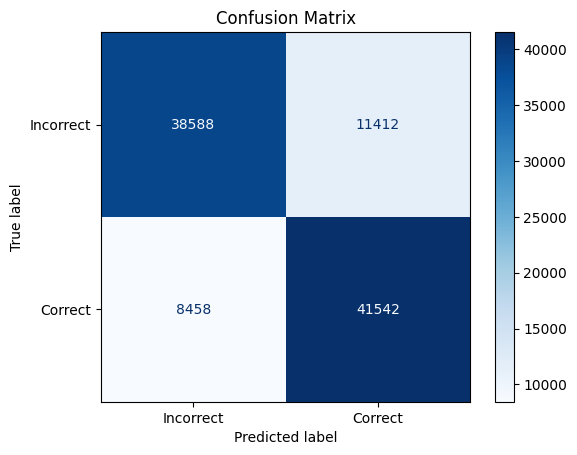

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the logic for predictions being correct or incorrect
def is_correct_prediction(row):
    if (row['emotion'] in [1,2, 3, 4, 5, 6] and row['label'] == 1) or (row['emotion'] in [0] and row['label'] == 0):
        return 1  # Correct
    elif (row['emotion'] in [1,2, 3, 4, 5, 6 ] and row['label'] == 0) or (row['emotion'] in [0] and row['label'] == 1):
        return 0  # Incorrect
    else:
        return 0  # Default to incorrect if no conditions match

# Apply the logic to the DataFrame
test_df['predicted_correct'] = test_df.apply(is_correct_prediction, axis=1)

# Actual labels and predictions for evaluation
y_true = test_df['label']
y_pred = test_df['predicted_correct']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect', 'Correct'])
disp.plot(cmap='Blues', values_format='d')

# Add title and labels
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.80
Precision: 0.78
Recall: 0.83
F1 Score: 0.81


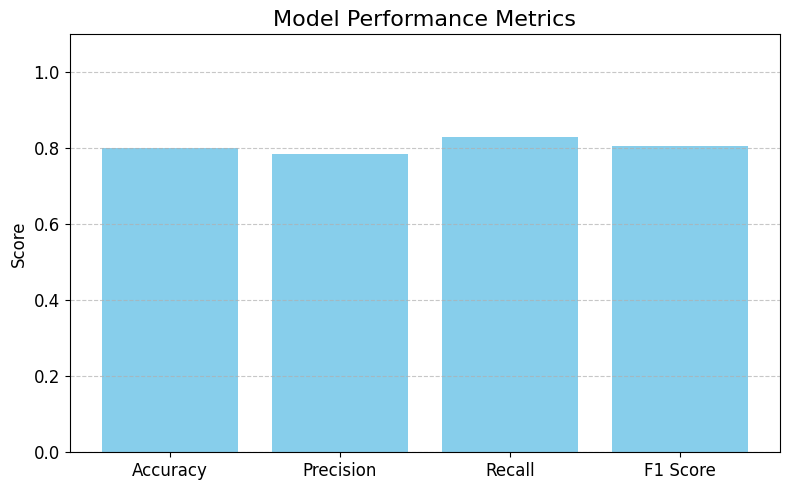

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Define the logic for predictions being correct or incorrect
def is_correct_prediction(row):
    if (row['emotion'] in [1, 2, 3, 4, 5, 6] and row['label'] == 1) or (row['emotion'] in [0] and row['label'] == 0):
        return 1  # Correct
    elif (row['emotion'] in [1, 2, 3, 4, 5, 6] and row['label'] == 0) or (row['emotion'] in [0] and row['label'] == 1):
        return 0  # Incorrect
    else:
        return 0  # Default to incorrect if no conditions match

# Apply the logic to the DataFrame
test_df['predicted_correct'] = test_df.apply(is_correct_prediction, axis=1)

# Actual labels and predictions for evaluation
y_true = test_df['label']
y_pred = test_df['predicted_correct']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Create a bar chart for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1.1)  # Set y-axis limit to include values up to 1.0
plt.title('Model Performance Metrics', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the bar chart
plt.tight_layout()
plt.show()
